# Прогнозирование музыкального жанра

## Данные

### Импорты

In [1]:
!pip install sweetviz
!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
train_data = pd.read_csv('/home/dolin/Music_genre_classification/kaggle_music_genre_test.csv')
test_data = pd.read_csv('/home/dolin/Music_genre_classification/kaggle_music_genre_test.csv')

### Обзор данных

Напишем функцию для простого EDA

In [6]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

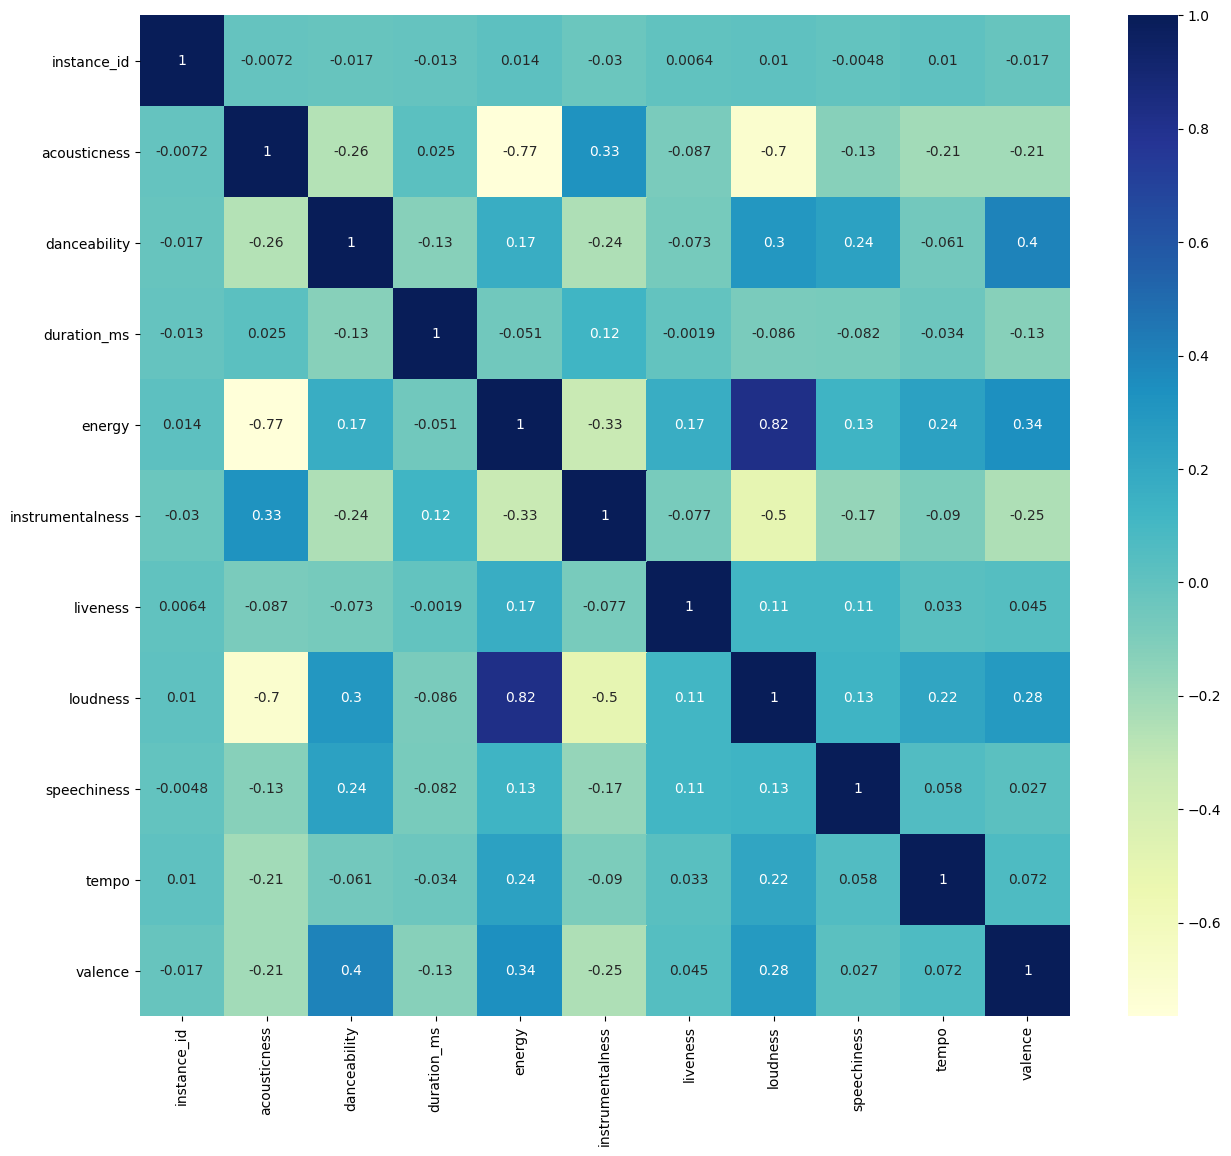

In [7]:
info_df(train_data)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

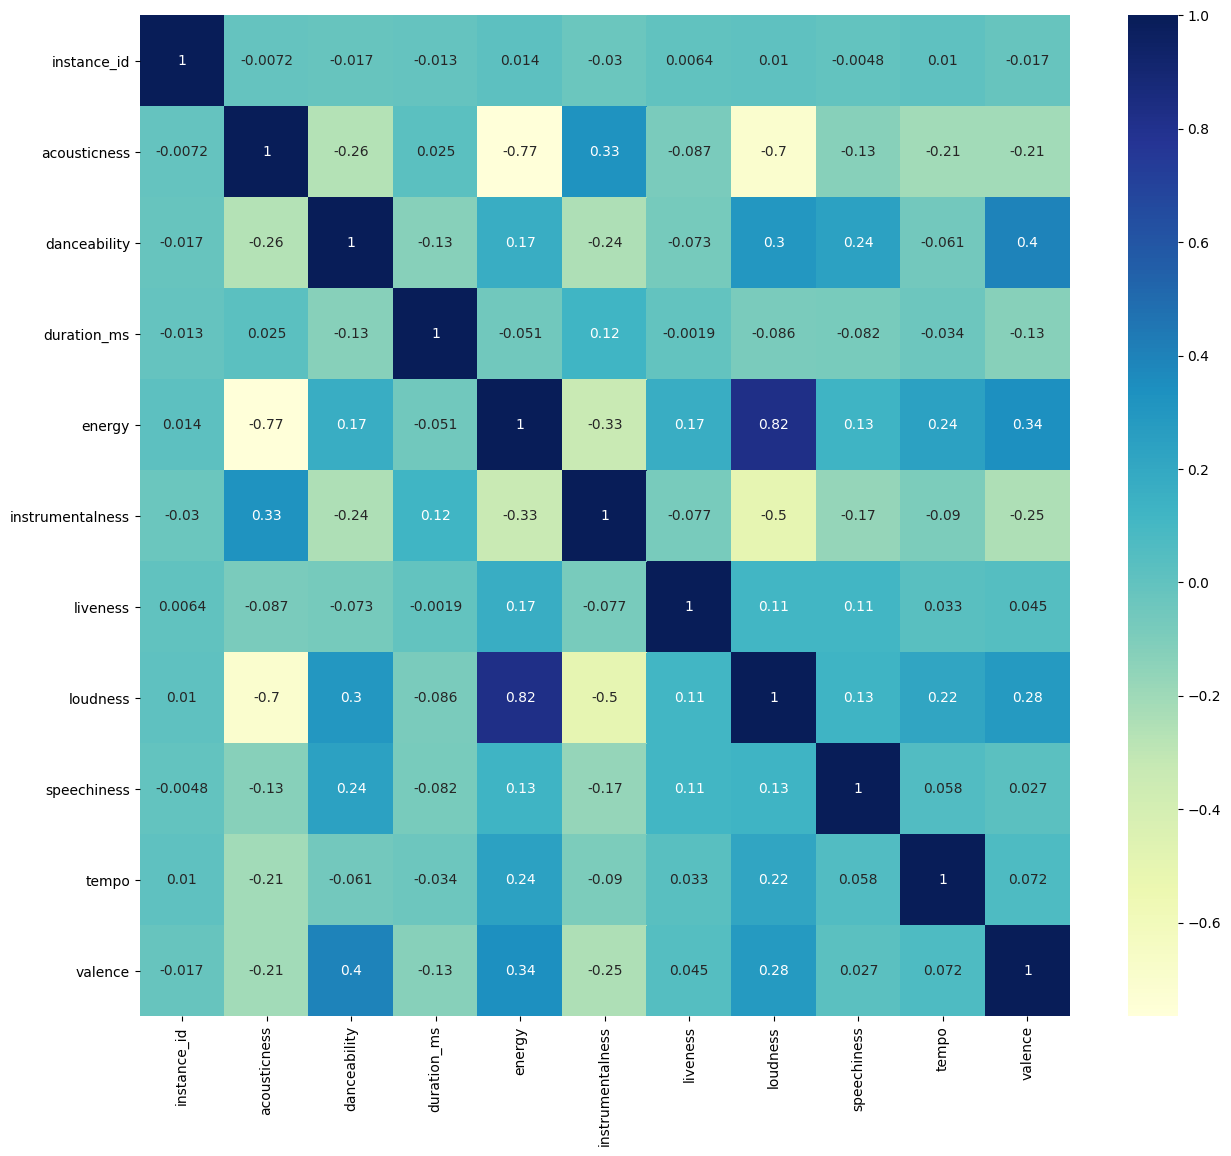

In [8]:
info_df(test_data)

Посмотрим на соотношение пропусков данных

In [10]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


In [18]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000
mode,2.900000


Заметим, что соотношение пропусков эквивалентно между тренировочным и тестовым датасетом

### Константы

In [9]:
RANDOM_STATE = 1220

## Предобработка и исследовательский анализ данных

### Приведение типов данных

#### Явные и неявные дубликаты

Проверим наличие явных дубликатов

In [12]:
train_data = train_data.drop('instance_id',axis=1)
train_data.duplicated().sum()

30

In [13]:
test_data = test_data.drop('instance_id',axis=1)
test_data.duplicated().sum()

30

In [14]:
train_data = train_data.drop_duplicates().reset_index(drop=True)
test_data = test_data.drop_duplicates().reset_index(drop=True)

Рассмотрим наличие неявных дубликатов

In [21]:
for i in ['key', 'mode', 'obtained_date']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
------------------------------------------------------------
mode
------------------------------------------------------------
['Minor' 'Major' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------


In [22]:
for i in ['key', 'mode', 'obtained_date']:
    print(i)
    print('------------------------------------------------------------')
    print(test_data[i].unique())
    print('------------------------------------------------------------')

key
------------------------------------------------------------
['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']
------------------------------------------------------------
mode
------------------------------------------------------------
['Minor' 'Major' nan]
------------------------------------------------------------
obtained_date
------------------------------------------------------------
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
------------------------------------------------------------
